In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import curve_fit
import lmfit as lmf
from scipy.stats import ttest_ind_from_stats as ttest

In [2]:
def myplot(DF,ax=None, color=None, **kwargs):
    m = DF.mean(1).to_numpy()
    s = DF.std(1).to_numpy()
    t = DF.index.values
    if ax:
        ax.plot(t,m, color= color, **kwargs)
        ax.fill_between(t, m-s, m+s, alpha = 0.1, color = color)
    else:
        plt.plot(t,m, color= color, **kwargs)
        plt.fill_between(t, m-s, m+s, alpha = 0.1, color = color)

In [3]:
# Assume Covariance = 0 
# Assume Blank is last index in Endpoint (EP)
# Assume Baseline (Off target, No induction, etc.) is second to last index in EP

def bgSubtractErr(A,Blank):
    return np.sqrt(np.std(A)**2 + np.std(Blank)**2)

def bgSubtract(A, Blank):
    return np.mean(A) - np.mean(Blank)
   
def foldActivationErr(A,Baseline,A_dev,Baseline_dev):
    return (np.mean(A)/np.mean(Baseline))*(np.sqrt((A_dev/A)**2 + (Baseline_dev/Baseline)**2))

def foldActivation(A, Baseline):
    return np.mean(A)/np.mean(Baseline)
    

In [4]:

pad = 5
xpad = 15
ypad = 11

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['figure.figsize'] = 8.5,11

plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '16'

color = 'black'
alpha = 0.2
markersize = 60
capsize = 8
elinewidth = 4
lw = 4
barwidth = 0.5

In [5]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager
import scipy.stats as stats

N = 5 # NUMBER OF FIGURES
P = 5 # NUMBER OF MAX PANNELS PER FIGURE
pad = 5
xpad = 15
ypad = 10

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['figure.figsize'] = 8.5,11

mpl.rcParams['axes.linewidth'] = 3
#mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = '16'

color = 'black'
alpha = 0.2
markersize = 60
capsize = 8
elinewidth = 4
lw = 4
barwidth = 0.5


def put_pval(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    # https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)
    
  
def get_kinetics(df, idx, measurement):
    newcols = pd.MultiIndex.from_arrays(np.roll(np.array([s.split(', ') for s in df.columns[1:]]),(1), axis=1).T, names = ('Measurement','Reaction ID','Replicate'))
    df = df.set_index('time')
    df.columns = newcols

    select = df[measurement].columns.get_level_values(0).isin([str(i) for i in idx])
    return df[measurement].loc[:, select]

In [ ]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220218_SYNZIP_DA303.csv'
layout = 'C:/Users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_021922.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 100, nrows = 130,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

In [ ]:
end = []

for i in exps:
    RFP =  RFPEx[exps[str(i)]].to_numpy()
    mean_values = RFP.mean(axis=1)
    index_min = np.argmin(mean_values)
    end.append(list(RFP[118]))
df = pd.DataFrame(end, index = list(exps.keys()))
df.to_csv('C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/synzip_021922_endpoint.csv')

In [ ]:
FA_2D = [
[59.1867388362652, 38.68200270636, 22.2543978349121, 6.1894451962111],
[18.8673883626522, 66.9891745602165, 51.1772665764547, 49.319350473613],
[10.4018944519621, 34.361299052774, 25.7198917456022, 24.1407307171854],
[5.78755074424899, 10.8795669824087, 32.9702300405954, 57.3085250338295]
]


ax = sns.heatmap(FA_2D, annot = True, xticklabels = ['1','5','10','25'], yticklabels =  ['1','5','10','25'], cmap="YlGnBu", cbar_kws={'label': 'Fold Activation'})
ax.invert_yaxis()
ax.set(xlabel = 'MCP DNA (nM)')
ax.set(ylabel = 'SoxS DNA (nM)')
ax.set(title = 'SYNZIP')

## 220224 ABA, SYNZIP, GA

In [ ]:
GA = [
[585,	544,	539],
[605,	550,	721],
[970,	979,	1123],
[753,	720,	621],
[654,	641,	675],
[638,	654,	738],
[1964,	2135,	2101],
[633,	665,	670],
[1099,	734,	991],
[966,	856,	1057],
[1907,	1802,	2429],
[650,	668,	604],
[863,	815,	779],
[751,	864,	1046],
[1472,	1714,	1721],
[752,	709,	776],
[599,	645,	658],
[342,	349,	339]
]

ABA = [
[957,	1470,	1840],
[1416,	1364,	1426],
[1737,	1787,	2691],
[816,	854,	778],
[984,	1236,	1186],
[3361,	3176,	3065],
[3519,	3213,	3329],
[1014,	1040,	945],
[959,	647,	937],
[5308,	4230,	3907],
[3408,	3120,	2969],
[1105,	896,	1031],
[1954,	1603,	1775],
[3662,	3467,	3611],
[2105,	2482,	2421],
[1377,	1379,	1327],
[568,	569,	561],
[342,	349,	339]

]


In [ ]:
#ABA
FA_2D = [
[4.845808383,3.556886228,	2.26497006,	6.44011976],
[4.754491018,	12.83233533,	18.58532934,	14.53592814],
[7.761976048,	13.51946108,	12.6751497,	8.949101796],
[2.122754491,	2.94760479,	2.997005988,	4.570359281]

]


ax = sns.heatmap(FA_2D, annot = True, xticklabels = ['1','5','10','25'], yticklabels =  ['1','5','10','25'], cmap="BuPu", cbar_kws={'label': 'Fold Activation'})
ax.invert_yaxis()
ax.set(xlabel = 'MCP DNA (nM)')
ax.set(ylabel = 'SoxS DNA (nM)')
ax.set(title = 'ABA')

In [ ]:
#GA
FA_2D = [
[0.731651376,	1.077981651,	2.05733945,	1.63646789],
[0.970183486,	1.146788991,	2.120412844,	1.870412844],
[2.341743119,	5.928899083,	5.857798165,	4.446100917],
[1.220183486,	1.075688073,	1.02293578,	1.384174312]


]


ax = sns.heatmap(FA_2D, annot = True,cmap = 'Blues', xticklabels = ['1','5','10','25'], yticklabels =  ['1','5','10','25'], cbar_kws={'label': 'Fold Activation'})
ax.invert_yaxis()
ax.set(xlabel = 'MCP DNA (nM)')
ax.set(ylabel = 'SoxS DNA (nM)')
ax.set(title = 'GA')

## 220228 ABA, GA titration

In [ ]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220228_aba_ga_2.csv'
layout = 'C:/Users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_02822.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 100, nrows = 130,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

In [ ]:
end = []

for i in exps:
    RFP =  RFPEx[exps[str(i)]].to_numpy()
    mean_values = RFP.mean(axis=1)
    index_min = np.argmin(mean_values)
    end.append(list(RFP[105]))
df = pd.DataFrame(end, index = list(exps.keys()))

a = df.iloc[0:6]
b = df.iloc[13:]
frames = [a,b]
EP = pd.concat(frames).to_numpy()
a = df.iloc[6:]
EP = a.to_numpy()
EP


In [ ]:
Err = []
FA = []
bgSubtract_Zero = bgSubtract(EP[-2], EP[-1])
bgSubtractErr_Zero = bgSubtractErr(EP[-2], EP[-1])

for i in range(len(EP[:-1])):
    
    bgSubtract_A = bgSubtract(EP[i], EP[-1])
    bgSubtractErr_A = bgSubtractErr(EP[i], EP[-1])
    
    FA.append(foldActivation(bgSubtract_A, bgSubtract_Zero))
    Err.append(foldActivationErr(bgSubtract_A, bgSubtract_Zero, bgSubtractErr_A, bgSubtractErr_Zero))

bg = []

for i in range(len(EP[:-1])):
    bg.append(bgSubtract(EP[i], EP[-1]))


In [ ]:

#ABA
ydata = [412.6666667,545.3333333,1552,3241.333333,426.6666667]
xdata = [0, .1, 1, 10, 100]
err = [28.18391977,40.99186911,497.7268327,187.1692639,39.62743158]


#ydata = [412.6666667,545.3333333,1552,3241.333333]
#xdata = [0, .1, 1, 10]
#err = [28.18391977,40.99186911,497.7268327,187.1692639]


def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, sigma= err)

In [ ]:

x_fit = sum([[c,c,c] for c in xdata],[])

plt.figure(figsize=(5,3.5))

plt.errorbar(xdata, ydata, err, fmt = 'ko--', alpha = .5)
y_fit = sum([[y, y+e, y-e] for y,e in zip(ydata,err)],[])
step_mod = lmf.models.StepModel(form = 'logistic')
pars = step_mod.guess(y_fit, x_fit)
mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
xnew = np.logspace(-1,3)
ynew = out.eval(x=xnew)
yerr = out.eval_uncertainty(x=xnew)
plt.plot(xnew,ynew,'r-')
plt.fill_between(xnew,ynew-yerr,ynew+yerr, color = 'red', alpha = .05)
plt.xscale('log')
plt.xlabel('[GA] (μM)', labelpad = xpad)
plt.ylabel('Fold Change', labelpad = ypad*1.1)
plt.title('GA-CRISPRa')

In [ ]:
x_fit = sum([[c,c,c] for c in xdata[:-1]],[])

plt.figure(figsize=(5,3.5))

plt.errorbar(xdata, ydata, err, fmt = 'ko--', alpha = .5)
y_fit = sum([[y, y+e, y-e] for y,e in zip(ydata[:-1],err[:-1])],[])
step_mod = lmf.models.StepModel(form = 'logistic')
pars = step_mod.guess(y_fit, x_fit)
mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
xnew = np.logspace(-1,1)
ynew = out.eval(x=xnew)
yerr = out.eval_uncertainty(x=xnew)
plt.plot(xnew,ynew,'r-')
plt.fill_between(xnew,ynew-yerr,ynew+yerr, color = 'red', alpha = .045)
plt.xscale('log')
plt.xlabel('[ABA] (μM)', labelpad = xpad)
plt.ylabel('Fold Change', labelpad = ypad*1.1)
plt.title('ABA-CRISPRa')
plt.savefig('aba_titration.png')

### 03/15/22 CRISPRa of i, OR gate

In [ ]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220314_AofI.csv'
layout = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_031422.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 68, nrows = 125,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

In [ ]:
end = []

for i in exps:
    RFP =  RFPEx[exps[str(i)]].to_numpy()
    mean_values = RFP.mean(axis=1)
    index_min = np.argmin(mean_values)
    end.append(list(RFP[98]))
df = pd.DataFrame(end, index = list(exps.keys()))


In [ ]:
bg_subtract = []
bg_subtract_err = []
for i in range(len(end[:-1])):
    bg_subtract.append(bgSubtract(end[i], end[-1]))
    bg_subtract_err.append(bgSubtractErr(end[i], end[-1]))
    
FA = []
for i in range(len(bg_subtract[13:])):
    FA.append(foldActivation(bg_subtract[13+i], bg_subtract[-1]))


## 042922 CRISPRa cascade and signal amplifier

In [ ]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220428_ABA.csv'
layout = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_042822.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 68, nrows = 92,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

In [ ]:
end = []

for i in exps:
    RFP =  RFPEx[exps[str(i)]].to_numpy()
    mean_values = RFP.mean(axis=1)
    index_min = np.argmin(mean_values)
    end.append(list(RFP[-1]))
df = pd.DataFrame(end, index = list(exps.keys()))

bg_subtract = []
bg_subtract_err = []
for i in range(len(end[:-1])):
    bg_subtract.append(bgSubtract(end[i], end[-1]))
    bg_subtract_err.append(bgSubtractErr(end[i], end[-1]))

## 0504022 DA9 titration

In [ ]:
data = [
[1901,	1629,	1873],
[945,	838,	654],
[671,	834,	861],
[535,	481,	869],
[555,	510,	496],
[492,	449,	455],
[339,	314,	332]
]

data_bg = []
data_bg_err = []

for d in data[:-1]:
    data_bg.append(bgSubtract(d, data[-1]))
    data_bg_err.append(bgSubtractErr(d, data[-1]))

In [ ]:
FA = []
FA_err = []
for i,d in enumerate(data_bg[:-1]):
    FA.append(foldActivation(d, data_bg[-1]))
    FA_err.append(foldActivationErr(d, data_bg[-1], data_bg_err[i],  data_bg_err[-1]))

## 051122 DA9 titration


In [ ]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220511_DA9_titration.csv'
layout = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_051122.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 68, nrows = 92,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

ep = []
for i in exps:
    ep.append(list(RFPEx[exps[i]].iloc[89]))


In [ ]:
ep_bg = []
ep_bg_err = []
for a in ep[:-1]:
    ep_bg.append(bgSubtract(a, ep[-1]))
    ep_bg_err.append(bgSubtractErr(a,ep[-1]))

In [ ]:
x = [20, 10, 5, 1, .1, .01, .001, 0]
plt.errorbar(x, ep_bg, yerr = ep_bg_err, linestyle = '--', color = 'orange', label = 'ABA-CRISPRa')
plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('RFP (au)')

In [ ]:
ep_fa = []
ep_fa_err = []
for i,a in enumerate(ep_bg[:-1]):
    ep_fa.append(foldActivation(a, ep_bg[-1]))
    ep_fa_err.append(foldActivationErr(a,ep_bg[-1],ep_bg_err[i], ep_bg_err[-1]))

In [ ]:
x = [20, 10, 5, 1, .1, .01, .001]
plt.errorbar(x, ep_fa, yerr = ep_fa_err, linestyle = '--', color = 'orange', label = 'ABA-CRISPRa')
plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('Fold Activation')

## 220518 GA, SYNZIP DA9 titration

In [179]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220518-competition-parallel.csv'
layout = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220518-competition-parallel_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 76, nrows = 128,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

{'G0R0': ['A1', 'A2', 'A3'],
 'G1R0': ['A4', 'A5', 'C4'],
 'S1': ['A6', 'B6', 'C6'],
 'S2': ['A7', 'B7', 'C7'],
 'S3': ['A8', 'B8', 'C8'],
 'S4': ['A9', 'B9', 'C9'],
 'S5': ['A10', 'B10', 'C10'],
 'S6': ['A11', 'B11', 'C11'],
 'S7': ['A12', 'B12', 'C12'],
 'blank': ['B3', 'B4', 'B5'],
 'G1R1': ['C1', 'C2', 'C3'],
 'G1R2': ['D1', 'D2', 'D3'],
 'G0R1': ['D4', 'E4', 'F4'],
 'G0R2': ['D5', 'E5', 'F5'],
 'G1': ['D6', 'E6', 'F6'],
 'G2': ['D7', 'E7', 'F7'],
 'G3': ['D8', 'E8', 'F8'],
 'G4': ['D9', 'E9', 'F9'],
 'G5': ['D10', 'E10', 'F10'],
 'G6': ['D11', 'E11', 'F11'],
 'G7': ['D12', 'E12', 'F12'],
 'G1R3': ['E1', 'E2', 'E3'],
 'G1R4': ['F1', 'F2', 'F3'],
 'G1R5': ['G1', 'G3', 'G4'],
 'G0R5': ['G8', 'G9', 'G10'],
 'G0R6': ['G11', 'G12', 'H11'],
 'G1R6': ['H1', 'H2', 'H3'],
 'G0R3': ['H4', 'H5', 'H6'],
 'G0R4': ['H7', 'H8', 'H9']}

In [180]:
blank = RFPEx[exps['blank']]

In [168]:
ep = []
for e in exps:
    if 'S' in e:
        #myplot(RFPEx[exps[e]])
        ep.append(RFPEx[exps[e]].iloc[-1])
ep.append(RFPEx[exps['blank']].iloc[-1])
x = [2, 1, .5, .1, .01, .001]


In [169]:
ep_bg = []
ep_bg_err = []
for a in ep[:-1]:
    ep_bg.append(bgSubtract(a, ep[-1]))
    ep_bg_err.append(bgSubtractErr(a,ep[-1]))

Text(0, 0.5, 'RFP (au)')

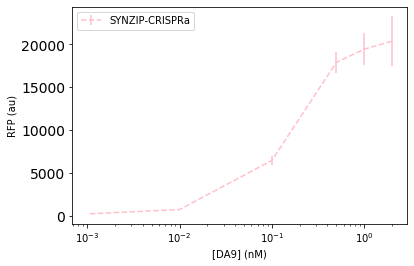

In [170]:
plt.errorbar(x, ep_bg[:-1], yerr = ep_bg_err[:-1], linestyle = '--', color = 'pink', label = 'SYNZIP-CRISPRa')
plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('RFP (au)')

In [171]:
ep_bg_err

[2896.771459554393,
 1867.010325508554,
 1268.6797161704062,
 564.0720994104685,
 80.52466840802403,
 25.486379804820366,
 11.71893055416463]

Text(0, 0.5, 'Fold Activation')

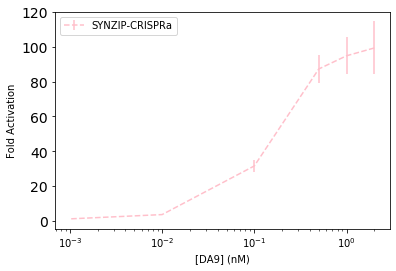

In [172]:
ep_fa = []
ep_fa_err = []
for i,a in enumerate(ep_bg[:-1]):
    ep_fa.append(foldActivation(a, ep_bg[-1]))
    ep_fa_err.append(foldActivationErr(a,ep_bg[-1],ep_bg_err[i], ep_bg_err[-1]))

ep_fa
plt.errorbar(x, ep_fa, yerr = ep_fa_err, linestyle = '--', color = 'pink', label = 'SYNZIP-CRISPRa')
plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('Fold Activation')

In [173]:
aba = [2.9237392373923736,
 4.0984009840098405,
 4.461254612546125,
 7.869618696186961,
 4.777367773677737,
 1.179581795817958,
 0.9471094710947108]

aba_err = [0.5146946807973681,
 0.8721236950206502,
 0.9051442374614043,
 1.4987886766241791,
 0.5717808257833711,
 0.1619078168940051,
 0.14524824838085443]

synzip = [99.34959349593497,
 94.86016260162602,
 87.28943089430894,
 31.614634146341462,
 3.6747967479674792,
 1.2130081300813007]

synzip_err = [15.229211902450082,
 10.599535026813816,
 7.949800812113036,
 3.2920142145276245,
 0.44544864897843933,
 0.1423543244329891]

In [206]:
max_aba = max(aba)
max_aba_err = aba_err[aba.index(max_aba)]
norm_ABA_FA = []
norm_ABA_FA_err = []
x_aba = [20, 10, 5, 1, .1, .01, .001]

for i,a in enumerate(aba):
    norm_ABA_FA.append(a/max_aba)
    norm_ABA_FA_err.append(foldActivationErr(a, max_aba, aba_err[i], max_aba_err))
    
max_szp = max(synzip)
max_szp_err = synzip_err[synzip.index(max_szp)]
norm_szp_FA = []
norm_szp_FA_err = []
x_szp = [2, 1, .5, .1, .01, .001]
for i,s in enumerate(synzip):
    norm_szp_FA.append(s/max_szp)
    norm_szp_FA_err.append(foldActivationErr(s, max_szp, synzip_err[i], max_szp_err))

Text(0, 0.5, 'Normalized Fold Activation')

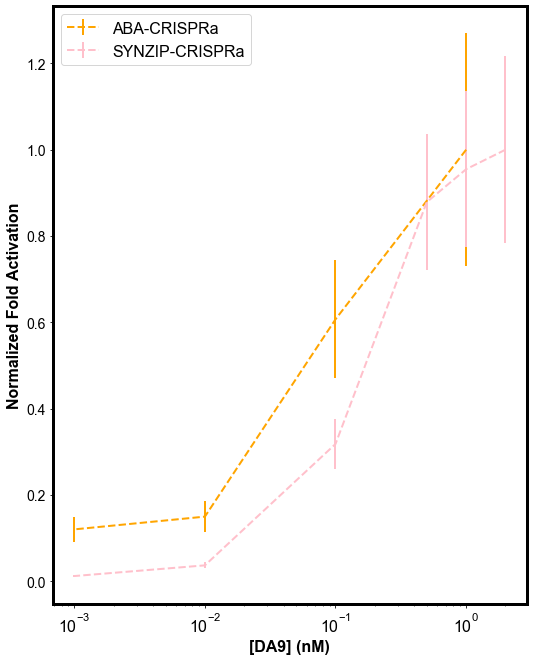

In [207]:
plt.errorbar(x_aba[3:], norm_ABA_FA[3:], yerr = norm_ABA_FA_err[3:], linestyle = '--', color = 'orange', label = 'ABA-CRISPRa')
plt.errorbar(x_szp, norm_szp_FA, yerr = norm_szp_FA_err, linestyle = '--', color = 'pink', label = 'SYNZIP-CRISPRa')

plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('Normalized Fold Activation')

## 220525 ABA, GA titration

In [182]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220524_ABA_GA.csv'
layout = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_052522.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 68, nrows = 94,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

{'1G': ['A1', 'B1', 'C1'],
 '2G': ['A2', 'B2', 'C2'],
 '3G': ['A3', 'B3', 'C3'],
 '4G': ['A4', 'B4', 'C4'],
 '5G': ['A5', 'B5', 'C5'],
 '6G': ['A6', 'B6', 'C6'],
 '7G': ['A7', 'B7', 'C7'],
 '1A': ['D1', 'E1', 'F1'],
 '2A': ['D2', 'E2', 'F2'],
 '3A': ['D3', 'E3', 'F3'],
 '4A': ['D4', 'E4', 'F4'],
 '5A': ['D5', 'E5', 'F5'],
 '7A': ['D7', 'E7', 'F7']}

In [181]:
blank = RFPEx[exps['blank']]

In [183]:
ep = []
for e in exps:
    if 'A' in e:
        #myplot(RFPEx[exps[e]])
        ep.append(RFPEx[exps[e]].iloc[-1])
ep.append(blank.iloc[-1])


In [184]:
ep_bg = []
ep_bg_err = []
for a in ep[:-1]:
    ep_bg.append(bgSubtract(a, ep[-1]))
    ep_bg_err.append(bgSubtractErr(a,ep[-1]))

In [185]:
ep_bg_err

[302.8567684933296,
 225.4748076590573,
 294.8800132633988,
 198.82879290708598,
 369.2906112475046,
 71.54641073379494]

Text(0, 0.5, 'RFP (au)')

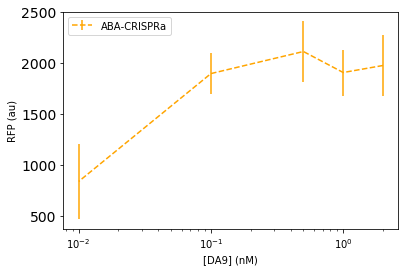

In [186]:
x = [2, 1, .5, .1, .01]
plt.errorbar(x, ep_bg[:-1], yerr = ep_bg_err[:-1], linestyle = '--', color = 'orange', label = 'ABA-CRISPRa')
plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('RFP (au)')

In [187]:
ep

[D1    2392
 E1    2662
 F1    1929
 Name: 930, dtype: int64,
 D2    2576
 E2    2124
 F2    2076
 Name: 930, dtype: int64,
 D3    2799
 E3    2513
 F3    2082
 Name: 930, dtype: int64,
 D4    2290
 E4    2468
 F4    1987
 Name: 930, dtype: int64,
 D5     873
 E5    1708
 F5     990
 Name: 930, dtype: int64,
 D7    763
 E7    625
 F7    603
 Name: 930, dtype: int64,
 B3    367
 B4    342
 B5    356
 Name: 1270, dtype: int64]

Text(0, 0.5, 'Fold Activation')

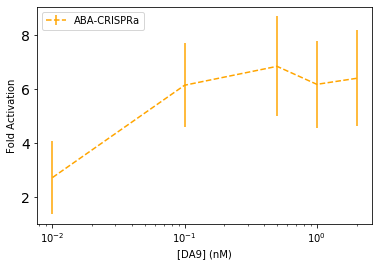

In [188]:
ep_fa = []
ep_fa_err = []
for i,a in enumerate(ep_bg[:-1]):
    ep_fa.append(foldActivation(a, ep_bg[-1]))
    ep_fa_err.append(foldActivationErr(a,ep_bg[-1],ep_bg_err[i], ep_bg_err[-1]))

ep_fa
plt.errorbar(x, ep_fa, yerr = ep_fa_err, linestyle = '--', color = 'orange', label = 'ABA-CRISPRa')
plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('Fold Activation')

In [189]:
ep_fa_err

[1.7768375183843643,
 1.6053702398874257,
 1.8499987789881065,
 1.5609039011557335,
 1.3508809889606463]

In [190]:
y = ['1G', '2G', '3G', '4G', '5G', '6G', '7G']
ep_GA = []
for e in y:
    ep_GA.append(RFPEx[exps[e]].iloc[-1])
ep_GA.append(blank.iloc[-1])
x = [2, 1, .5, .1, .01, .001]

ep_GA_bg = []
ep_GA_bg_err = []
for a in ep_GA[:-1]:
    ep_GA_bg.append(bgSubtract(a, ep_GA[-1]))
    ep_GA_bg_err.append(bgSubtractErr(a,ep_GA[-1]))

Text(0, 0.5, 'RFP (au)')

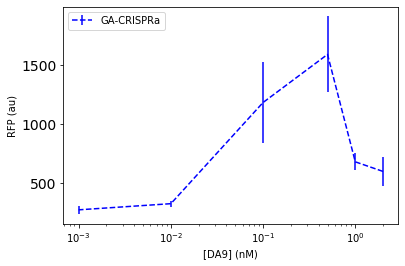

In [191]:
plt.errorbar(x, ep_GA_bg[:-1], yerr = ep_GA_bg_err[:-1], linestyle = '--', color = 'blue', label = 'GA-CRISPRa')
plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('RFP (au)')

In [192]:
ep_GA_fa_err

NameError: name 'ep_GA_fa_err' is not defined

Text(0, 0.5, 'Fold Activation')

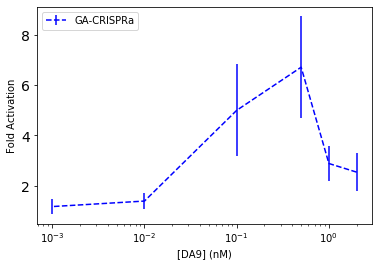

In [193]:
ep_GA_fa = []
ep_GA_fa_err = []
for i,a in enumerate(ep_GA_bg[:-1]):
    ep_GA_fa.append(foldActivation(a, ep_GA_bg[-1]))
    ep_GA_fa_err.append(foldActivationErr(a,ep_GA_bg[-1],ep_GA_bg_err[i], ep_GA_bg_err[-1]))

plt.errorbar(x, ep_GA_fa, yerr = ep_GA_fa_err, linestyle = '--', color = 'blue', label = 'GA-CRISPRa')
plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('Fold Activation')

Text(0, 0.5, 'RFP')

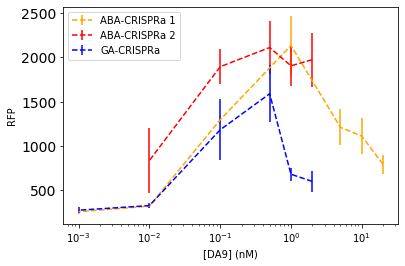

In [194]:
ep_bg_ABA_1 = [792.3333333333333,
 1110.6666666666667,
 1209.0,
 2132.6666666666665,
 1294.6666666666667,
 319.66666666666663,
 256.66666666666663,
 271.0]

ep_bg_err_ABA_1 = [107.36955910416239,
 200.7059762161777,
 204.2367906785324,
 327.94037398418766,
 53.343748982946025,
 25.197001585285676,
 26.78722747048592,
 30.45214825481666]

x_ABA_1 = [20, 10, 5, 1, .1, .01, .001]


ep_bg_ABA_2 = [1972.6666666666665,
 1903.6666666666665,
 2109.6666666666665,
 1893.3333333333335,
 835.3333333333333,
 308.66666666666663]

ep_bg_err_ABA_2 = [302.8567684933296,
 225.4748076590573,
 294.8800132633988,
 198.82879290708598,
 369.2906112475046,
 71.54641073379494]

x_ABA_2 = [2, 1, .5, .1, .01]

ep_bg_GA = [598.6666666666666,
 680.0,
 1588.3333333333333,
 1181.6666666666667,
 326.0,
 274.0,
 236.33333333333337]

ep_bg_err_GA = [120.6132478443208,
 72.86517229330713,
 320.9665957004803,
 345.4478574578546,
 26.025628394590846,
 36.23074201098657,
 52.86040315985324]

x_GA = [2, 1, .5, .1, .01, .001]

plt.errorbar(x_ABA_1, ep_bg_ABA_1[:-1], yerr = ep_bg_err_ABA_1[:-1], linestyle = '--', color = 'orange', label = 'ABA-CRISPRa 1')
plt.errorbar(x_ABA_2, ep_bg_ABA_2[:-1], yerr = ep_bg_err_ABA_2[:-1], linestyle = '--', color = 'red', label = 'ABA-CRISPRa 2')
plt.errorbar(x_GA, ep_bg_GA[:-1], yerr = ep_bg_err_GA[:-1], linestyle = '--', color = 'blue', label = 'GA-CRISPRa')

plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('RFP')

Text(0, 0.5, 'Fold Activation')

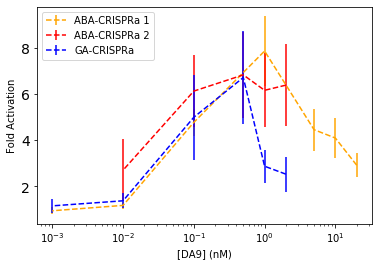

In [195]:
ABA_1_FA = [2.9237392373923736,
 4.0984009840098405,
 4.461254612546125,
 7.869618696186961,
 4.777367773677737,
 1.179581795817958,
 0.9471094710947108]

ABA_1_FA_err = [0.5146946807973681,
 0.8721236950206502,
 0.9051442374614043,
 1.4987886766241791,
 0.5717808257833711,
 0.1619078168940051,
 0.14524824838085443]

ABA_2_FA = [6.3909287257019445,
 6.167386609071275,
 6.834773218142549,
 6.133909287257021,
 2.7062634989200864]

ABA_2_FA_err = [1.7768375183843643,
 1.6053702398874257,
 1.8499987789881065,
 1.5609039011557335,
 1.3508809889606463]

GA_FA = [2.5331452750352605,
 2.877291960507757,
 6.720733427362481,
 4.999999999999999,
 1.3794076163610718,
 1.1593794076163608]

GA_FA_err = [0.7625475332141478,
 0.7136024772788649,
 2.025864842020893,
 1.840449278432783,
 0.32759433417212136,
 0.30124295008867624]

plt.errorbar(x_ABA_1, ABA_1_FA, yerr = ABA_1_FA_err, linestyle = '--', color = 'orange', label = 'ABA-CRISPRa 1')
plt.errorbar(x_ABA_2, ABA_2_FA, yerr = ABA_2_FA_err, linestyle = '--', color = 'red', label = 'ABA-CRISPRa 2')
plt.errorbar(x_GA, GA_FA, yerr = GA_FA_err, linestyle = '--', color = 'blue', label = 'GA-CRISPRa')

plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('Fold Activation')

Text(0, 0.5, 'Fold Activation')

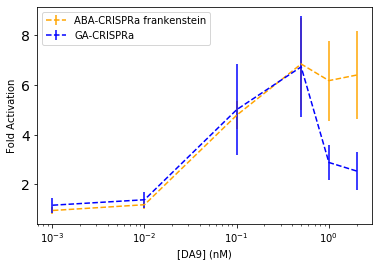

In [196]:
ABA_chimera = [6.3909287257019445,
 6.167386609071275,
 6.834773218142549,
 4.777367773677737,
 1.179581795817958,
 0.9471094710947108]

ABA_chimera_err = [1.7768375183843643,
 1.6053702398874257,
 1.8499987789881065,
 0.5717808257833711,
 0.1619078168940051,
 0.14524824838085443]

x_chimera = [2, 1, .5, .1, .01, .001]

plt.errorbar(x_chimera, ABA_chimera, yerr = ABA_chimera_err, linestyle = '--', color = 'orange', label = 'ABA-CRISPRa frankenstein')
plt.errorbar(x_GA, GA_FA, yerr = GA_FA_err, linestyle = '--', color = 'blue', label = 'GA-CRISPRa')

plt.legend(loc ='upper left')
plt.xscale('log')
plt.xlabel('[DA9] (nM)')
plt.ylabel('Fold Activation')

NameError: name 'xpad' is not defined

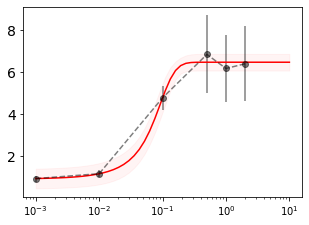

In [197]:
import lmfit as lmf

x_fit = sum([[c,c,c] for c in x_chimera],[])

plt.figure(figsize=(5,3.5))

plt.errorbar(x_chimera, ABA_chimera, ABA_chimera_err, fmt = 'ko--', alpha = .5)

y_fit = sum([[y, y+e, y-e] for y,e in zip(ABA_chimera, ABA_chimera_err)],[])
step_mod = lmf.models.StepModel(form = 'logistic')
pars = step_mod.guess(y_fit, x_fit)
mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
xnew = np.logspace(-3,1)
ynew = out.eval(x=xnew)
yerr = out.eval_uncertainty(x=xnew)

x_a = xnew
y_a = ynew
err_a = yerr


plt.plot(xnew,ynew,'r-')
plt.fill_between(xnew,ynew-yerr,ynew+yerr, color = 'red', alpha = .045)
plt.xscale('log')
plt.xlabel('[DA9] (nM)', labelpad = xpad)
plt.ylabel('Fold Change', labelpad = ypad*1.1)
plt.title('ABA-CRISPRa')



In [198]:
out

NameError: name 'xpad' is not defined

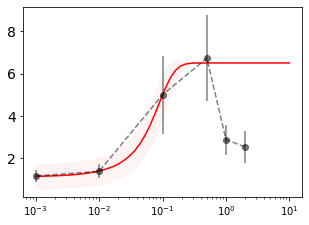

In [199]:
import lmfit as lmf

x_fit = sum([[c,c,c] for c in x_chimera[2:]],[])

plt.figure(figsize=(5,3.5))

plt.errorbar(x_chimera, GA_FA, GA_FA_err, fmt = 'ko--', alpha = .5)

y_fit = sum([[y, y+e, y-e] for y,e in zip(GA_FA[2:], GA_FA_err[2:])],[])
step_mod = lmf.models.StepModel(form = 'logistic')
pars = step_mod.guess(y_fit, x_fit)

pars['amplitude'].min = 4
pars['amplitude'].max = 6.5
pars['amplitude'].value = 5
pars['center'].min = .01
pars['center'].max = .2

mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
xnew = np.logspace(-3,1)
ynew = out.eval(x=xnew)
yerr = out.eval_uncertainty(x=xnew)

x_g = xnew
y_g = ynew
err_g = yerr


plt.plot(xnew,ynew,'r-')
plt.fill_between(xnew,ynew-yerr,ynew+yerr, color = 'red', alpha = .045)
plt.xscale('log')
plt.xlabel('[DA9] (nM)', labelpad = xpad, fontsize = 16)
plt.ylabel('Fold Change', labelpad = ypad*1.1, fontsize = 16)
plt.title('GA-CRISPRa',fontsize = 16)



In [200]:
out

NameError: name 'xpad' is not defined

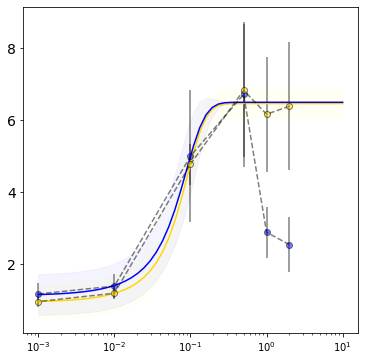

In [201]:
plt.figure(figsize=(6,6))
plt.plot(x_a,y_a,'r-', color = 'gold')
plt.plot(x_g,y_g,'r-', color = 'blue')
#plt.plot(x_s,y_s,'p-')
plt.errorbar(x_chimera, GA_FA, GA_FA_err, fmt = 'ko--', mfc = 'blue',alpha = .5)
plt.errorbar(x_chimera, ABA_chimera, ABA_chimera_err, fmt = 'ko--',mfc = 'gold', alpha = .5)


plt.fill_between(x_a, y_a-err_a, y_a+err_a, color = 'yellow', alpha = .045)
plt.fill_between(x_g, y_g-err_g, y_g+err_g, color = 'blue', alpha = .045)
#plt.fill_between(x_s, y_s-err_s, y_s+err_s, color = 'pink', alpha = .045)

plt.xscale('log')
plt.xlabel('[DA9] (nM)', labelpad = xpad, fontsize = 24)
plt.ylabel('Fold Change', labelpad = ypad*1.1, fontsize = 24)
plt.title('ABA, GA-CRISPRa', fontsize = 24)

plt.savefig('da9_titrate.svg')

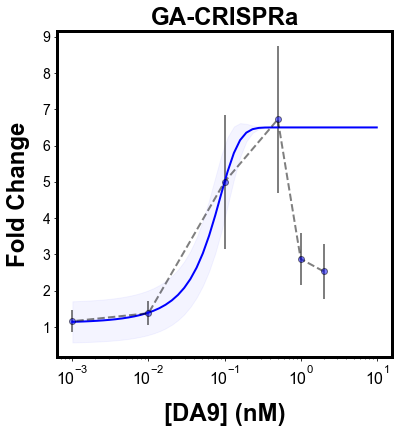

In [204]:
plt.figure(figsize=(6,6))
plt.plot(x_g,y_g,'r-', color = 'blue')
plt.errorbar(x_chimera, GA_FA, GA_FA_err, fmt = 'ko--', mfc = 'blue',alpha = .5)

plt.fill_between(x_g, y_g-err_g, y_g+err_g, color = 'blue', alpha = .045)

plt.xscale('log')
plt.xlabel('[DA9] (nM)', labelpad = xpad, fontsize = 24)
plt.ylabel('Fold Change', labelpad = ypad*1.1, fontsize = 24)
plt.title('GA-CRISPRa', fontsize = 24)

plt.savefig('da9_ga_titrate.svg')

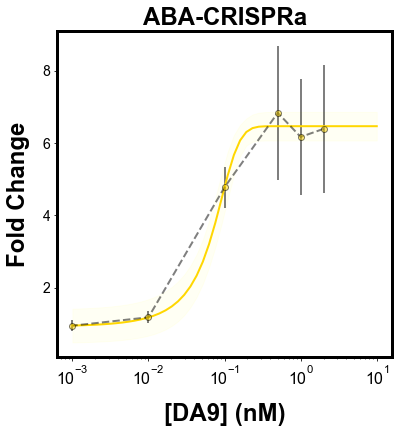

In [205]:
plt.figure(figsize=(6,6))
plt.plot(x_a,y_a,'r-', color = 'gold')
plt.errorbar(x_chimera, ABA_chimera, ABA_chimera_err, fmt = 'ko--',mfc = 'gold', alpha = .5)


plt.fill_between(x_a, y_a-err_a, y_a+err_a, color = 'yellow', alpha = .045)

plt.xscale('log')
plt.xlabel('[DA9] (nM)', labelpad = xpad, fontsize = 24)
plt.ylabel('Fold Change', labelpad = ypad*1.1, fontsize = 24)
plt.title('ABA-CRISPRa', fontsize = 24)

plt.savefig('da9_aba_titrate.svg')

Text(0.5, 0, '[GA] (μM)')

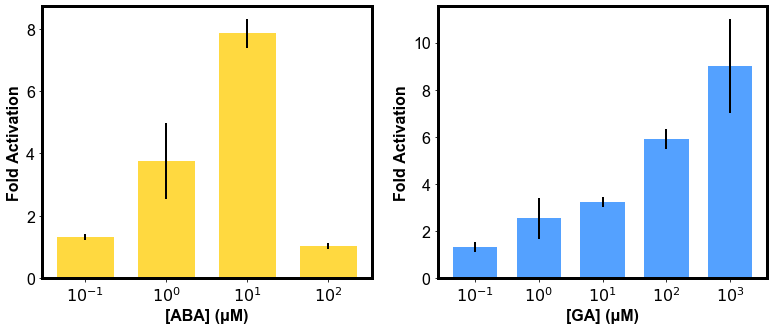

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (13, 5))

#ABA, FC
FC_aba = [1.321486268,3.760904685,7.8546042,1.033925687]
xdata_aba = ['$10^{-1}$','$10^0$','$10^1$','$10^2$']
err_aba = [0.099334093,1.206123181,0.453560413,0.096027702]

#GA, FC
FC_ga =[1.329577465,2.532394366,3.226760563,5.912676056,8.992957746]
xdata_ga = ['$10^{-1}$','$10^0$','$10^1$','$10^2$', '$10^3$']
err_ga =[0.214718298,0.871491891,0.226217528,0.410192982,1.998758293]


ax[0].bar(xdata_aba,FC_aba, yerr = err_aba,width = .7, color = (1,.85,.25))
ax[0].set_ylabel('Fold Activation', fontsize = 16)
ax[0].set_xlabel('[ABA] (μM)', fontsize = 16)

ax[1].bar(xdata_ga,FC_ga, yerr = err_ga, width = .7, color = (.33,.63,1))
ax[1].set_ylabel('Fold Activation', fontsize = 16)
ax[1].set_xlabel('[GA] (μM)', fontsize = 16)

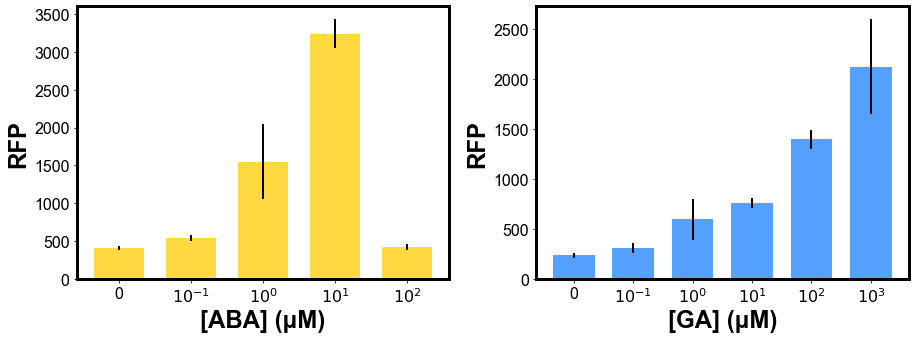

In [63]:
#ABA
rfp_aba = [412.6666667, 545.3333333, 1552, 3241.333333, 426.6666667]
xdata_aba = ['0','$10^{-1}$','$10^0$','$10^1$','$10^2$']
err_aba = [28.18391977, 40.99186911, 497.7268327, 187.1692639,39.62743158]

#GA
rfp_ga = [236.6666667,314.6666667,599.3333333,763.6666667,1399.333333,2128.333333]
xdata_ga = ['0','$10^{-1}$','$10^0$','$10^1$','$10^2$', '$10^3$']
err_ga = [28.72861524,50.81666393,206.2530808,53.53814839,97.07900563,473.0394628]

fig, ax = plt.subplots(1, 2, figsize = (13, 5))

ax[0].bar(xdata_aba,rfp_aba, yerr = err_aba,width = .7, color = (1,.85,.25))
ax[0].set_ylabel('RFP', fontsize = 24)
ax[0].set_xlabel('[ABA] (μM)', fontsize = 24)
ax[0].arrow(10,10,190,190)

ax[1].bar(xdata_ga,rfp_ga, yerr = err_ga, width = .7, color = (.33,.63,1))
ax[1].set_ylabel('RFP', fontsize = 24)
ax[1].set_xlabel('[GA] (μM)', fontsize = 24)
fig.tight_layout()

plt.savefig('molecule_titration.svg')

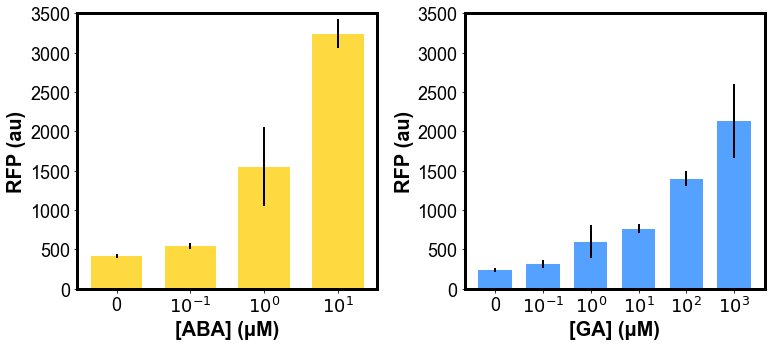

In [70]:
#ABA
rfp_aba = [412.6666667, 545.3333333, 1552, 3241.333333]
xdata_aba = ['0','$10^{-1}$','$10^0$','$10^1$']
err_aba = [28.18391977, 40.99186911, 497.7268327, 187.1692639]

#GA
rfp_ga = [236.6666667,314.6666667,599.3333333,763.6666667,1399.333333,2128.333333]
xdata_ga = ['0','$10^{-1}$','$10^0$','$10^1$','$10^2$', '$10^3$']
err_ga = [28.72861524,50.81666393,206.2530808,53.53814839,97.07900563,473.0394628]

fig, ax = plt.subplots(1, 2, figsize = (11, 5))

ax[0].bar(xdata_aba,rfp_aba, yerr = err_aba,width = .7, color = (1,.85,.25))
ax[0].set_ylabel('RFP (au)', fontsize = 20, weight='bold')
ax[0].set_xlabel('[ABA] (μM)', fontsize = 20, weight='bold')
ax[0].set_xticklabels(xdata_aba, fontsize=18)
ax[0].arrow(10,10,190,190)

ax[1].bar(xdata_ga,rfp_ga, yerr = err_ga, width = .7, color = (.33,.63,1))
ax[1].set_ylabel('RFP (au)', fontsize = 20, weight='bold')
ax[1].set_xticklabels(xdata_ga, fontsize=18)
ax[1].set_xlabel('[GA] (μM)', fontsize = 20, weight='bold')
fig.tight_layout()
ax[0].set_ylim([0,3500])
ax[1].set_ylim([0,3500])

plt.savefig('molecule_titration.svg')

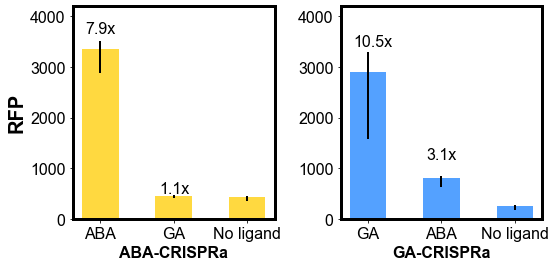

In [69]:
import numpy as np

aba = [[3333,	3365,	3026],
[450,	459,	420],
[422,	435,	381]]

aba_fc = []
for i in range(0,2):
    aba_fc.append(np.average(np.array(aba[i])/np.array(aba[-1])).round(1))

ga = [[2911,	2516,	1969],
[690,681,	798],
[258,204,	248]]

ga_fc = []
for i in range(0,2):
    ga_fc.append(np.average(np.array(ga[i])/np.array(ga[-1])).round(1))

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
aba_labels = ['ABA', 'GA', 'No ligand']
ga_labels = ['GA', 'ABA', 'No ligand']
for i, a in enumerate(aba):
    ax[0].bar(aba_labels[i], a, yerr = np.std(a), width = .5, color = (1,.85,.25))
    if i < 2:
        ax[0].text(i-.2,a[i]*1.1, s = str(aba_fc[i])+'x')
for i, g in enumerate(ga):
    ax[1].bar(ga_labels[i], g, yerr = np.std(g), width = .5, color = (.33,.63,1))    
    if i < 2:
        ax[1].text(i-.2,g[i]+500, s = str(ga_fc[i])+'x')
ax[0].set_ylim(0,4200)
ax[0].set_xlabel('ABA-CRISPRa')
ax[1].set_ylim(0,4200)
ax[1].set_xlabel('GA-CRISPRa')
ax[0].set_ylabel('RFP', fontsize = 20)
plt.tight_layout()

plt.savefig('orthogonal.svg')

In [ ]:
fc = np.array(allm_l) / np.array(allm_d)
for i in range(len(fc)):
    plt.text(i-0.4,allm_l[i]*1.2,'{x:.{d}f}x'.format(x=fc[i], d =1))
    plt.annotate("", xy=(i-0.105, allm_d[i]), xytext=(i-0.105, allm_l[i]),arrowprops=dict(arrowstyle="<->"))

## SYNZIP Phase shift

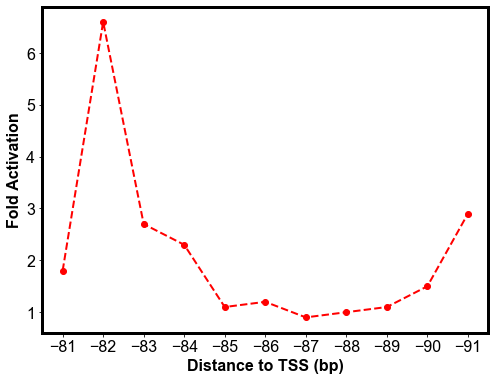

In [196]:
ydata =[[1490,	1316,	1350],			
[4537,	5655,	4698],				
[1109,	2395,	2557],				
[1592,	1671,	1895],				
[794,	907,	810],				
[921,	834,	914],				
[669,	671,	647],				
[771,	739,	666],				
[892,	845,	799],				
[1067,	1177,	1270],				
[1974,	2145,	2529],				
[813,	739,	729]]
xdata = [-81, -82, -83, -84, -85, -86, -87, -88, -89, -90, -91]

fA = []
for i, s in enumerate(ydata):
    fA.append(np.average(np.array(s)/np.array(ydata[-1])).round(1))

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
plt.scatter(xdata, fA[:-1], color = 'red')
plt.plot(xdata, fA[:-1], color = 'red', linestyle = '--')
plt.ylabel('Fold Activation')
plt.xticks(xdata)
plt.xlabel('Distance to TSS (bp)')
plt.gca().invert_xaxis()
plt.savefig('synzip_phaseshift.png')

### SYNZIP frankenstein data

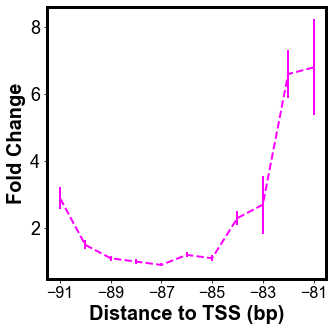

In [8]:
ydata =[[6512,	3914, 5213],			
[4537,	5655,	4698],				
[1109,	2395,	2557],				
[1592,	1671,	1895],				
[794,	907,	810],				
[921,	834,	914],				
[669,	671,	647],				
[771,	739,	666],				
[892,	845,	799],				
[1067,	1177,	1270],				
[1974,	2145,	2529],				
[813,	739,	729]]
xdata = [-81, -82, -83, -84, -85, -86, -87, -88, -89, -90, -91]

fA = []
std = []
for i, s in enumerate(ydata):
    fA.append(np.average(np.array(s)/np.array(ydata[-1])).round(1))
    #std.append(np.std(s))
    std_1 = (np.mean(s)/np.mean(ydata[-1]))*(np.sqrt((np.std(s)/np.mean(s))**2 + (np.std(ydata[-1]/np.mean(ydata[-1]))**2)))

    std.append(std_1)
        
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
#plt.scatter(xdata, fA[:-1], color = 'red')
plt.errorbar(xdata, fA[:-1], yerr = std[:-1], color = 'magenta', linestyle = '--')
#plt.plot(xdata, fA[:-1], color = 'red', linestyle = '--')
plt.ylabel('Fold Change', fontsize = 20, weight = 'bold')
plt.xticks([-81, -83, -85, -87, -89, -91], fontsize = 16)
plt.xlabel('Distance to TSS (bp)', fontsize = 20, weight = 'bold')
plt.yticks(fontsize = 18)

#plt.gca().invert_xaxis()
plt.savefig('synzip_phaseshift.svg')

### new promoter comparison

Text(0, 0.5, 'Fold Activation')

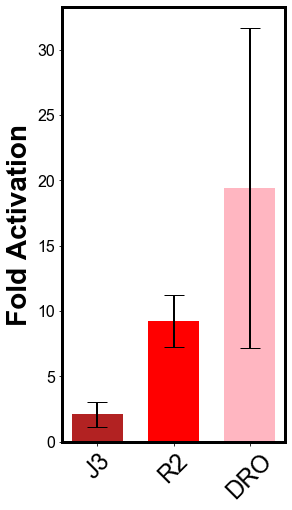

In [23]:
plt.figure(figsize=(4,8))
J3 = [2.0865547512706, 0.927576115609829]
DA = [19.4089834515366, 12.2780257188624]
R2 = [9.24390243902439, 1.98171439998724]
x_labels = ('J3', 'R2','DRO')
x_pos = [.85, 1,1.15]
plt.bar(x_pos[0], J3[0], yerr = J3[1], width = .1,  capsize = 10, color = 'firebrick')
plt.bar(x_pos[1], R2[0], yerr=R2[1], width = .1, capsize = 10, color = 'red')
plt.bar(x_pos[2], DA[0], yerr = DA[1], width = .1, capsize = 10,color = 'lightpink')
plt.xticks(x_pos, x_labels)
plt.xticks(rotation = 45, fontsize = 24)

plt.ylabel('Fold Activation', fontsize = 28)

#ticklabels = [t for t in plt.gca().get_xticklabels()]
#for l in x_labels:
#    i = x_labels.index(l)
#    ticklabels[i].set_fontweight("bold")
    
    
#plt.tight_layout()


## ABA / GA OR

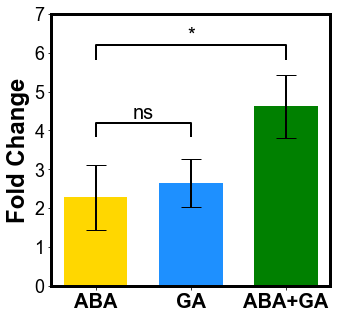

In [54]:
ABA = [2.28169014084507, 0.834243592546728]					
GA = [2.64788732394366, 0.622782459281578]			
ABA_GA = [4.62441314553991, 0.81697387890426]


plt.figure(figsize=(5,5))

x_labels = ('ABA', 'GA','ABA+GA')
x_pos = [.85, 1,1.15]
plt.bar(x_pos[0], ABA[0], yerr = ABA[1], width = .1,  capsize = 10, color = 'gold')
plt.bar(x_pos[1], GA[0], yerr=GA[1], width = .1, capsize = 10, color = 'dodgerblue')
plt.bar(x_pos[2], ABA_GA[0], yerr = ABA_GA[1], width = .1, capsize = 10, color = 'green')
plt.xticks(x_pos, x_labels, fontsize = 24)
plt.xticks(rotation = 45, fontsize = 16)

plt.ylabel('Fold Change', fontsize = 24)
plt.yticks(fontsize = 18)
ticklabels = [t for t in plt.gca().get_xticklabels()]
for l in x_labels:
    i = x_labels.index(l)
    ticklabels[i].set_fontweight("bold")
    ticklabels[i].set_fontsize(20)
    ticklabels[i].set_rotation(0)
    
plt.ylim(0,7)

x_pos = [.85,.85,1]
y_loc =[3.5, 3.5, 3.5]
put_pval(1, 2, 'ns', x_pos, y_loc, yerr=None, dh=.05, barh=.05, fs=20, maxasterix=None)

x_pos = [.85,.85,1.15]
y_loc =[5.5, 5.5, 5.5]
put_pval(1, 2, '*', x_pos, y_loc, yerr=None, dh=.05, barh=.05, fs=20, maxasterix=None)

    
plt.savefig('ABA-GA-OR.svg')

## CRISPRa of a cascade

Text(0.5, 0, '[DA4.DA9] (nM)')

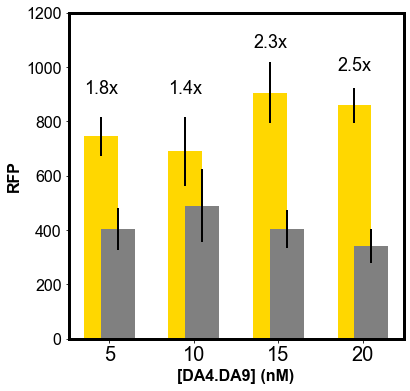

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

x= np.array([20, 15, 10, 5])
aba = [858.666666666667, 905, 689.333333333333, 744.666666666667]
aba_err = [63.6797543267176, 111.999007932114, 125.35638085962, 70.3499190554695]
no_aba = [341, 403.666666666667, 490.333333333333, 403.666666666667]
no_aba_err = [63.0114628019731, 69.6594892634481, 135.695328667652, 76.8230289547202]
ax.bar(x-.5, aba, yerr=aba_err, color = 'gold', width = 2)
ax.bar(x+.5, no_aba, yerr=no_aba_err, color = 'gray', width  =2)
plt.xticks(x, x, fontsize = 20)
plt.ylim(0,1200)

ax.text(i+1.5,aba[0]*1.05, s = str(1.8)+'x', fontsize = 18)
ax.text(i+6.5,aba[0]*1.05, s = str(1.4)+'x', fontsize = 18)
ax.text(i+11.5,aba[0]*1.25, s = str(2.3)+'x', fontsize = 18)
ax.text(i+16.5,aba[0]*1.15, s = str(2.5)+'x', fontsize = 18)

plt.ylabel('RFP')
plt.xlabel('[DA4.DA9] (nM)')


In [7]:
## zero data from 030522 a of a cascade
plus =  np.array([530, 538, 546]) - 50
minus = np.array([476, 516, 570]) - 50

plus_avg = np.mean(plus)
minus_avg = np.mean(minus)
plus_dev = np.std(plus)
minus_dev = np.std(minus)

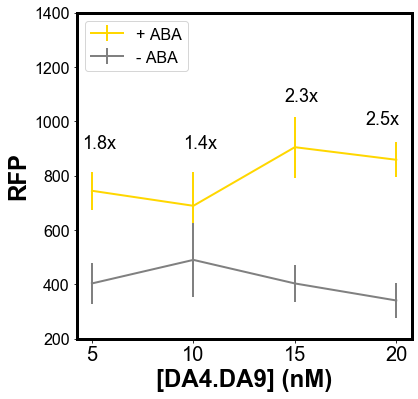

In [8]:
## includes frankenstein data

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

x= np.array([20, 15, 10, 5]) #, 0 ])
aba = [858.666666666667, 905, 689.333333333333, 744.666666666667] #, plus_avg]
aba_err = [63.6797543267176, 111.999007932114, 125.35638085962, 70.3499190554695] #, plus_dev]
no_aba = [341, 403.666666666667, 490.333333333333, 403.666666666667] #, minus_avg]
no_aba_err = [63.0114628019731, 69.6594892634481, 135.695328667652, 76.8230289547202] #, minus_dev]
ax.errorbar(x, aba, yerr=aba_err, color = 'gold', label = '+ ABA')
ax.errorbar(x, no_aba, yerr=no_aba_err, color = 'gray', label = '- ABA')
plt.xticks(x, x, fontsize = 20)
plt.ylim(0,1200)


ax.text(4.5,aba[0]*1.05, s = str(1.8)+'x', fontsize = 18)
ax.text(9.5,aba[0]*1.05, s = str(1.4)+'x', fontsize = 18)
ax.text(14.5,aba[0]*1.25, s = str(2.3)+'x', fontsize = 18)
ax.text(18.5,aba[0]*1.15, s = str(2.5)+'x', fontsize = 18)

plt.ylabel('RFP', fontsize = 24)
plt.xlabel('[DA4.DA9] (nM)', fontsize = 24)
plt.ylim(200, 1400)
plt.legend(loc = 'upper left')
plt.savefig('ABA_cascade.svg')

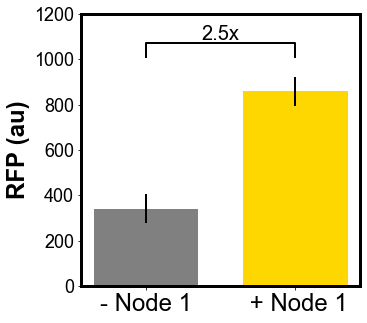

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

x= np.array([1, 2])
aba = [341, 858.666666666667]
aba_err = [63.0114628019731, 63.679754326717]

ax.bar(x[0], aba[0], yerr=aba_err[0], color = 'gray', width = .7)
ax.bar(x[1], aba[1], yerr=aba_err[1], color = 'gold', width  =.7)
plt.xticks(x, x, fontsize = 20)
plt.ylim(0,1200)



plt.ylabel('RFP (au)', fontsize = 24)
plt.xticks([1,2],['- Node 1', ' + Node 1'], fontsize = 24)
plt.yticks(fontsize = 18)
#plt.xlabel('[DA4.DA9] (nM)')
x_pos = [1,1,2]
y_loc =[950, 950, 950]
#put_pval(1, 2, ttest(aba[0], aba_err[0], 3, aba[1], aba_err[1], 3)[1], x_pos, y_loc, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
#ax.text(1.85,aba[1]*1.15, s = str(2.5)+'x', fontsize = 18)
put_pval(1, 2, '2.5x', x_pos, y_loc, yerr=None, dh=.05, barh=.05, fs=20, maxasterix=None)
plt.savefig('cascade.svg')

In [4]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220618_Fans.csv'
layout = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_061822.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 68, nrows = 1,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

{'1p_A_pos': ['A1', 'B1', 'C1'],
 '1p_A_neg': ['A2', 'B2', 'C2'],
 '2p_eq_A_pos': ['A3', 'B3', 'C3'],
 '2p_eq_A_neg': ['A4', 'B4', 'C4'],
 '2p_half_A_pos': ['A5', 'B5', 'C5'],
 '2p_half_A_neg': ['A6', 'B6', 'C6'],
 '3p_eq_A_pos': ['A7', 'B7', 'C7'],
 '3p_eq_A_neg': ['A8', 'B8', 'C8'],
 '3p_third_A_pos': ['A9', 'B9', 'C9'],
 '3p_third_A_neg': ['A10', 'B10', 'C10'],
 '1p_B_pos': ['A11', 'B11', 'C11'],
 '1p_B_neg': ['A12', 'B12', 'C12'],
 '2p_eq_B_pos': ['D1', 'E1', 'F1'],
 '2p_eq_B_neg': ['D2', 'E2', 'F2']}

<BarContainer object of 10 artists>

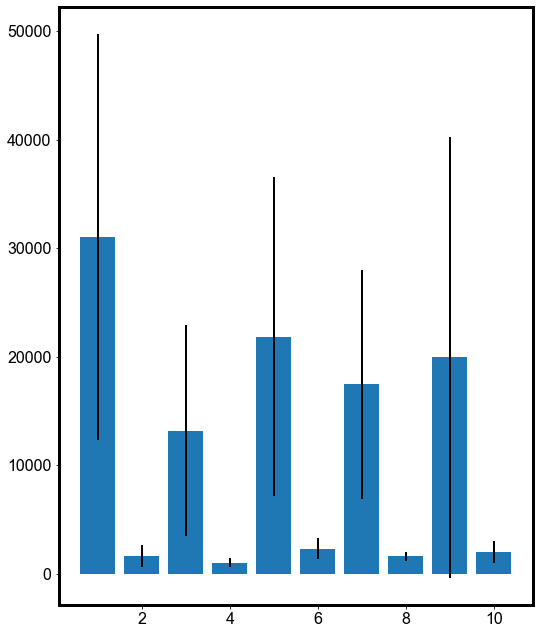

In [5]:
A_ep = []
A_dev = []

x = np.linspace(1,10,10)
for a in exps:
    if 'A' in a:
        A_ep.append(np.mean(RFPEx[exps[a]], axis = 1)[0])
        A_dev.append(np.std(RFPEx[exps[a]], axis =1)[0])
        
plt.bar(x, A_ep, yerr = A_dev)

<BarContainer object of 4 artists>

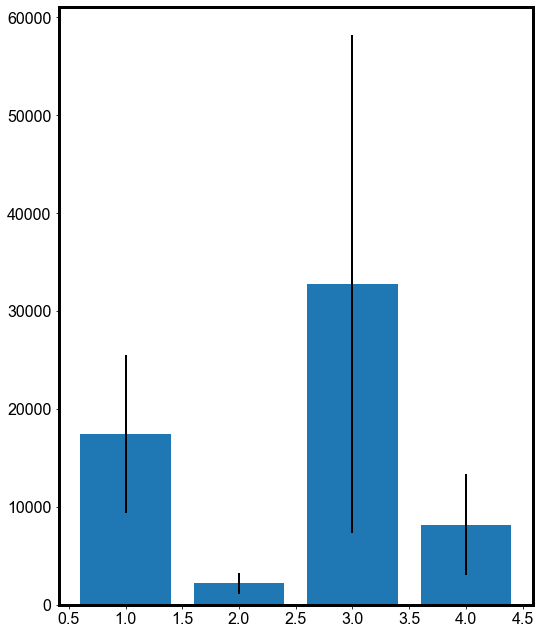

In [6]:
B_ep = []
B_dev = []

x = np.linspace(1,4,4)
for b in exps:
    if 'B' in b:
        B_ep.append(np.mean(RFPEx[exps[b]], axis = 1)[0])
        B_dev.append(np.std(RFPEx[exps[b]], axis =1)[0])
        
plt.bar(x, B_ep, yerr = B_dev)

In [7]:
end = []
for i in exps:
    end.append(list(RFPEx[exps[i]].iloc[0]))

In [8]:
# Assume Covariance = 0 
# Assume Blank is last index in Endpoint (EP)
# Assume Baseline (Off target, No induction, etc.) is second to last index in EP

def bgSubtractErr(A,Blank):
    return np.sqrt(np.std(A)**2 + np.std(Blank)**2)

def bgSubtract(A, Blank):
    return np.mean(A) - np.mean(Blank)
   
def foldActivationErr(A,Baseline,A_dev,Baseline_dev):
    return (np.mean(A)/np.mean(Baseline))*(np.sqrt((A_dev/A)**2 + (Baseline_dev/Baseline)**2))

def foldActivation(A, Baseline):
    return np.mean(A)/np.mean(Baseline)

def backgroundSubtractKinetic(Exp, Blank):
    return RFPEx[exps[Exp]].mean(axis = 1) - RFPEx[exps[Blank]].mean(axis = 1)

#Calculate propagation of error for background subtractions
def backgroundSubtractKineticErr(Exp,Blank):
    return np.sqrt(RFPEx[exps[Exp]].std(axis = 1)**2 + RFPEx[exps[Blank]].std(axis = 1)**2)


In [9]:
fa = []
fa_err = []

for i in range(0,10,2):
    fa.append(foldActivation(A_ep[i], A_ep[i+1]))
    fa_err.append(foldActivationErr(A_ep[i], A_ep[i+1], A_dev[i], A_dev[i+1]))

## 06/22/22

In [209]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220622-fans_and_cascades.csv'
layout = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_220622.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 68, nrows = 125,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

{'LH_0': ['A1', 'B1', 'C1'],
 'LH_1': ['A2', 'B2', 'C2'],
 'LH_2': ['A3', 'B3', 'C3'],
 'LH_3': ['A4', 'B4', 'C4'],
 'lowLH_0': ['A5', 'B5', 'C5'],
 'lowLH_1': ['A6', 'B6', 'C6'],
 'highLH_0': ['A7', 'B7', 'C7'],
 'highLH_1': ['A8', 'B8', 'C8'],
 'c_1': ['A9', 'B9', 'C9'],
 'c_0': ['A10', 'B10', 'C10'],
 'blank': ['A11', 'B11', 'C11'],
 '1p_A_pos': ['D1', 'E1', 'F1'],
 '1p_A_neg': ['D2', 'E2', 'F2'],
 '2p_eq_A_pos': ['D3', 'E3', 'F3'],
 '2p_eq_A_neg': ['D4', 'E4', 'F4'],
 '2p_half_A_pos': ['D5', 'E5', 'F5'],
 '2p_half_A_neg': ['D6', 'E6', 'F6'],
 '3p_eq_A_pos': ['D7', 'E7', 'F7'],
 '3p_eq_A_neg': ['D8', 'E8', 'F8'],
 '3p_third_A_pos': ['D9', 'E9', 'F9'],
 '3p_third_A_neg': ['D10', 'E10', 'F10'],
 '4p_eq_A_pos': ['D11', 'E11', 'F11'],
 '4p_eq_A_neg': ['D12', 'E12', 'F12'],
 '4p_fourth_A_pos': ['G1', 'G2', 'G3'],
 '4p_fourth_A_neg': ['G4', 'G5', 'G6'],
 'leak': ['G10', 'G11', 'G12']}

<BarContainer object of 14 artists>

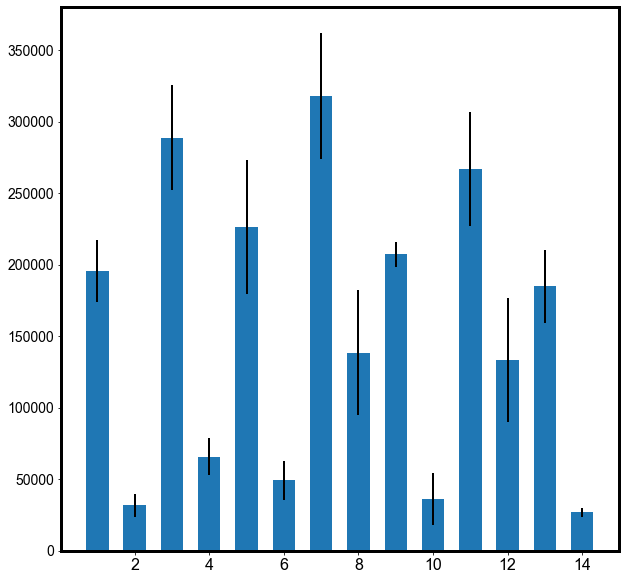

In [210]:
exps['1p_A_pos'] = ['D1','E1']
exps['1p_A_neg'] = ['D2','E2']
#exps['3p_third_A_neg'] = ['E10', 'F10']

A_ep = []
A_dev = []

x = np.linspace(1,14,14)
for a in exps:
    if 'A' in a:
        A_ep.append(np.mean(RFPEx[exps[a]], axis = 1).iloc[-1])
        A_dev.append(np.std(RFPEx[exps[a]], axis =1).iloc[-1])

plt.figure(figsize=(10,10))
plt.bar(x, A_ep, yerr = A_dev, width = .6)

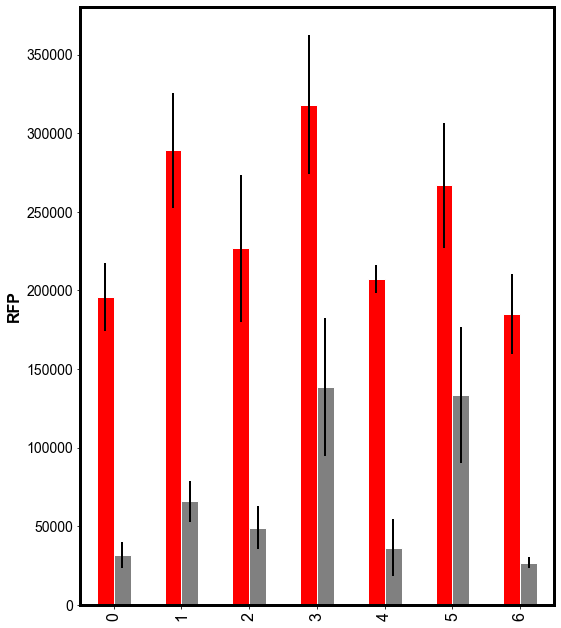

In [211]:
fig, ax = plt.subplots()

d = {'Column 1': [A_ep[i] for i in range(0,13,2)],
      'Column 2': [A_ep[i] for i in range(1,14,2)]}

e = {'Column 1': [A_dev[i] for i in range(0,13,2)],
      'Column 2': [A_dev[i] for i in range(1,14,2)]}

df = pd.DataFrame(d)
df.plot(kind='bar', edgecolor='white', linewidth=1, yerr = e, color = ['red','gray'], ax = ax)

plt.ylabel('RFP')
plt.legend().remove()
plt.show()

fig.savefig('fans.svg')

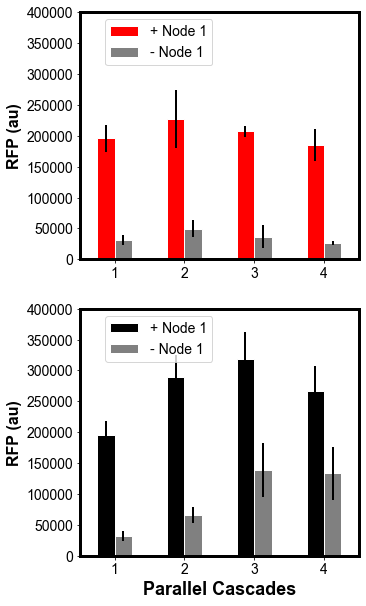

In [212]:
e_df = pd.DataFrame(e)

fig, ax = plt.subplots(2,1, figsize = (5,10))
ax[0].set_yticks([0, 50000,100000, 150000, 200000, 250000, 300000, 350000, 400000])
df.iloc[[0,2,4,6]].plot(kind='bar',edgecolor='white', linewidth=1, yerr = e_df.iloc[[0,2,4,6]].to_numpy().T, color = ['red','gray'], ax = ax[0])
ax[0].set_xticklabels(labels=['1', '2', '3', '4'], fontsize = 14, rotation = 0)
ax[0].legend(labels= ['+ Node 1', '- Node 1'], fontsize = 14,loc='upper right', bbox_to_anchor=(0.5, 1))
df.iloc[[0,1,3,5]].plot(kind='bar',edgecolor='white', linewidth=1, yerr = e_df.iloc[[0,1,3,5]].to_numpy().T, color = ['black','gray'], ax = ax[1])
ax[1].set_xticklabels(labels=['1', '2', '3', '4'], fontsize = 14, rotation  =0)
ax[1].legend(labels= ['+ Node 1', '- Node 1'], fontsize = 14, loc='upper right', bbox_to_anchor=(0.5, 1))

ax[0].set_ylim(0,400000)
ax[1].set_ylim(0,400000)
ax[0].set_ylabel('RFP (au)', fontsize = 16)
ax[1].set_ylabel('RFP (au)', fontsize = 16)
ax[1].set_xlabel('Parallel Cascades', fontsize = 18)


plt.show()

fig.savefig('fans_raw.svg')

In [213]:
fa = []
fa_err = []

for i in range(0,14,2):
    fa.append(foldActivation(A_ep[i], A_ep[i+1]))
    fa_err.append(foldActivationErr(A_ep[i], A_ep[i+1], A_dev[i], A_dev[i+1]))

In [214]:
RFPEx[exps['3p_third_A_neg']]

,D10,E10,F10
0,434,410,355
10,427,399,344
20,420,390,350
30,420,384,366
40,418,378,365
...,...,...,...
1200,61260,29702,18307
1210,61218,29710,18318
1220,61365,29706,18321
1230,61423,29709,18329


Text(0.5, 0, '# of Parallel Cascades')

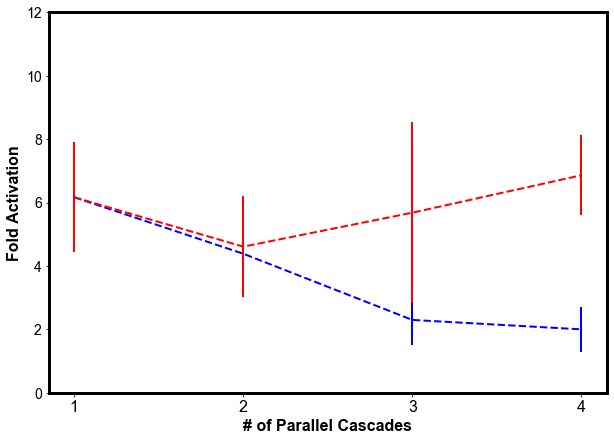

In [215]:
plt.figure(figsize=(10,7))
x = [1, 2, 3, 4]
split = [fa[i] for i in range(0,7,2)]
split_err = [fa_err[i] for i in range(0,7,2)]
eq = [fa[i] for i in range(1, 7, 2)] 
eq = np.insert(eq, 0, fa[0])
eq_err = [fa_err[i] for i in range(1, 7, 2)]
eq_err = np.insert(eq_err, 0, fa_err[0])

plt.errorbar(x, eq, yerr = eq_err,  color = 'blue', linestyle = '--')
plt.errorbar(x, split, yerr=split_err,  color = 'red', linestyle = '--')
plt.ylim(0,12)
plt.xticks([1, 2, 3, 4])
plt.ylabel('Fold Activation')
plt.xlabel('# of Parallel Cascades')


In [14]:
eq

array([6.16703629, 4.3855755 , 2.29783776, 2.00089455])

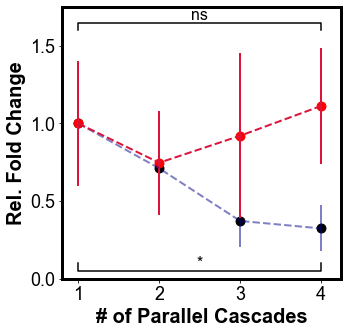

In [216]:
eq_norm = [i/eq[0] for i in eq]
split_norm = [i/split[0] for i in split]

eq_err_norm = [foldActivationErr(eq[i], eq[0], eq_err[i], eq_err[0]) for i in range(0,4)]
split_err_norm = [foldActivationErr(split[i], split[0], split_err[i], split_err[0]) for i in range(0,4)]

plt.figure(figsize=(5,5))

x_fake = [.8,2.2,3.2,4.2]
plt.errorbar(x, eq_norm, yerr = eq_err_norm,  color = 'darkblue', linestyle = '--', alpha = .5)
#plt.plot(x_eq,y_eq, color = 'blue')
#plt.fill_between(x_eq,y_eq-yerr_eq,y_eq+yerr_eq, color = 'blue', alpha = .045)


plt.errorbar(x, split_norm, yerr=split_err_norm,  color = 'crimson', linestyle = '--')
#plt.plot(x_split,y_split, color = 'red')
#plt.fill_between(x_split,y_split-yerr_split,y_split+yerr_split, color = 'red', alpha = .045)

plt.scatter(x, eq_norm,  color = 'black', marker=  'o', s = 80)
plt.scatter(x, split_norm, color = 'red', s= 80)

plt.ylim(0,1.75)
plt.xlim(.8,4.25)
plt.xticks([1, 2, 3, 4], fontsize = 18)
plt.yticks([0,.5,1,1.5], fontsize = 18)
plt.ylabel('Rel. Fold Change', fontsize = 20, weight = 'bold')
plt.xlabel('# of Parallel Cascades', fontsize = 20)

#plt.text(3.98, 1.5, '*', fontsize = 'x-large')

x1, x2 = 1, 4  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 1.6, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col, fontsize = 16)

x1, x2 = 1, 4  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = .1, -.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

plt.savefig('fans_FA.svg')

In [37]:
eq

array([6.16703629, 4.3855755 , 2.29783776, 2.00089455])

In [27]:
ttest(split_norm[0], split_err_norm[0], 3, split_norm[3], split_err_norm[3], 3)

Ttest_indResult(statistic=-0.3557458300329893, pvalue=0.7399991968046657)

In [34]:
ttest(split[0], split_err[0], 3, split[3], split_err[3], 3)

Ttest_indResult(statistic=-0.5588200861953727, pvalue=0.6060892401864827)

In [35]:
ttest(eq[0], eq_err[0], 3, eq[3], eq_err[3], 3)

Ttest_indResult(statistic=3.8317879442951144, pvalue=0.018589630998617348)

In [309]:
import lmfit as lmf

x_fit = sum([[c,c,c] for c in x],[])
y_fit = sum([[y, y+e, y-e] for y,e in zip(eq_norm, eq_err_norm)],[])
step_mod = lmf.models.PowerLawModel()
pars = step_mod.guess(y_fit, x_fit)
mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
x_eq = np.linspace(1,4)
y_eq = out.eval(x=xnew)
yerr_eq = out.eval_uncertainty(x=x_eq)


In [290]:

x_fit = sum([[c,c,c] for c in x],[])
y_fit = sum([[y, y+e, y-e] for y,e in zip(split_norm, split_err_norm)],[])
step_mod = lmf.models.LinearModel()
pars = step_mod.guess(y_fit, x_fit)
mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
x_split = np.linspace(0,4)
y_split = out.eval(x=xnew)
yerr_split = out.eval_uncertainty(x=x_split)


In [56]:
'''
GA_FA =[0.731651376146789,
 0.9701834862385322,
 2.341743119266055,
 1.2201834862385321,
 1.0779816513761467,
 1.1467889908256879,
 5.928899082568806,
 1.0756880733944953,
 2.0573394495412844,
 2.120412844036697,
 5.8577981651376145,
 1.0229357798165137,
 1.6364678899082568,
 1.8704128440366974,
 4.446100917431193,
 1.3841743119266054,
 1.0]
'''

GA_FA = [ 1.2201834862385321,
 1.0756880733944953,
 1.0229357798165137,
 1.3841743119266054,
 2.341743119266055,
 5.928899082568806,
 5.8577981651376145,
 4.446100917431193,
 0.9701834862385322,
 1.1467889908256879,
 2.120412844036697,
 1.8704128440366974,
0.731651376146789,
 1.0779816513761467,
 2.0573394495412844,
 1.6364678899082568]

'''
GA_Err = [0.09697793536955883,
 0.26013664130693487,
 0.3179518734952659,
 0.22145779355345005,
 0.1076269335110302,
 0.18226659021835734,
 0.5820036333067631,
 0.11136666825662583,
 0.5573090005149219,
 0.33937048950715154,
 1.0758267961539776,
 0.13021413761435136,
 0.1873118703263905,
 0.4497413187156039,
 0.5593186607547487,
 0.1556510797615432,
 0.12482628279071353]
'''

GA_Err = [ 0.22145779355345005,
 0.11136666825662583,
 0.13021413761435136,
 0.1556510797615432,
 0.3179518734952659,
 0.5820036333067631,
 1.0758267961539776,
 0.5593186607547487,
 0.26013664130693487,
 0.18226659021835734,
 0.33937048950715154,
 0.4497413187156039,
0.09697793536955883,
0.1076269335110302,
 0.5573090005149219,
 0.4497413187156039]


'''
ABA_FA = [4.845808383233533,
 4.754491017964072,
 7.761976047904191,
 2.122754491017964,
 3.55688622754491,
 12.832335329341316,
 13.519461077844309,
 2.947604790419161,
 2.2649700598802394,
 18.585329341317365,
 12.6751497005988,
 2.9970059880239517,
 6.440119760479042,
 14.535928143712573,
 8.949101796407184,
 4.570359281437126,
 1.0]    
'''

ABA_FA = [ 2.122754491017964,
 2.947604790419161,
 2.9970059880239517,
 4.570359281437126,
 7.761976047904191,
 13.519461077844309,
 12.6751497005988,
 8.949101796407184,
 4.754491017964072,
 12.832335329341316,
 18.585329341317365,
 14.535928143712573,
 4.845808383233533,
 3.55688622754491,
 2.2649700598802394,
 6.440119760479042]

'''
ABA_Err = [1.6305021051903839,
 0.1703867086177884,
 1.9783020678259469,
 0.15005687815637417,
 0.4974188269431505,
 0.6335535950266062,
 0.6577719363870412,
 0.1950894489110807,
 0.6412384291795363,
 2.7290401649859466,
 0.8758743476570816,
 0.396022787155085,
 0.6632010895230949,
 0.5163949274964216,
 0.774470961721447,
 0.15734655319208993,
 0.0349158796098521]
'''
ABA_Err = [ 0.15005687815637417,
 0.1950894489110807,
 0.396022787155085,
 0.15734655319208993,
 1.9783020678259469,
 0.6577719363870412,
 0.8758743476570816,
 0.774470961721447,
 0.1703867086177884,
 0.6335535950266062,
 2.7290401649859466,
 0.5163949274964216,
 1.6305021051903839,
 0.4974188269431505,
 0.6412384291795363,
 0.6632010895230949,
]

SYNZIP_FA =[59.18673883626525,
 38.68200270635996,
 22.25439783491205,
 6.189445196211098,
 18.867388362652235,
 66.98917456021653,
 51.17726657645469,
 49.31935047361301,
 10.401894451962113,
 34.36129905277403,
 29.684709066305828,
 24.14073071718539,
 5.787550744248987,
 10.879566982408663,
 32.97023004059541,
 57.30852503382952,
 1.0]

SYNZIP_Err = [8.15958794617842,
 5.33297576299188,
 3.7500638828847253,
 1.16184420081329,
 4.639241231159957,
 17.394724651534123,
 8.363074065449597,
 11.742433012832208,
 2.385980045866987,
 7.137645471614383,
 4.150117107235026,
 4.033381407030832,
 0.8488547550543927,
 2.0213803292395043,
 4.609717127555072,
 8.19313493517055,
 0.1948203241441428]

[Text(0.5, 1, 'SYNZIP')]

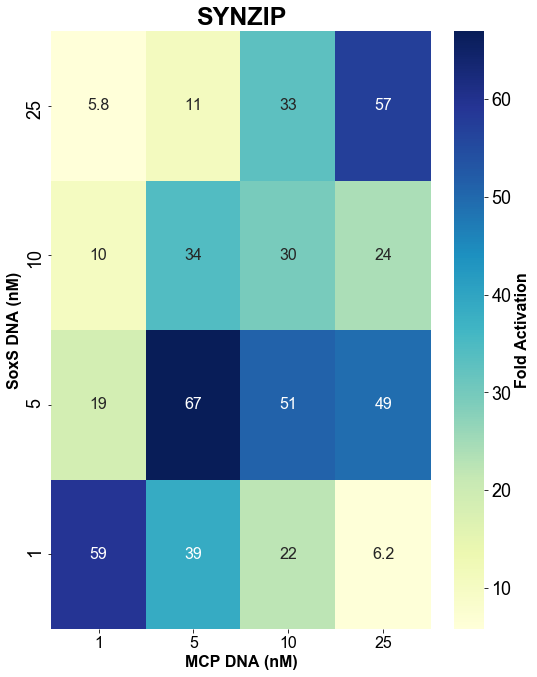

In [71]:
'''
FA_2D = [
[59.1867388362652, 38.68200270636, 22.2543978349121, 6.1894451962111],
[18.8673883626522, 66.9891745602165, 51.1772665764547, 49.319350473613],
[10.4018944519621, 34.361299052774, 25.7198917456022, 24.1407307171854],
[5.78755074424899, 10.8795669824087, 32.9702300405954, 57.3085250338295]
]
'''

FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(SYNZIP_FA,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(SYNZIP_Err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []


ax = sns.heatmap(FA_2D, annot = True, xticklabels = ['1','5','10','25'], yticklabels =  ['1','5','10','25'], cmap="YlGnBu", cbar_kws={'label': 'Fold Activation'})
ax.invert_yaxis()
ax.set(xlabel = 'MCP DNA (nM)')
ax.set(ylabel = 'SoxS DNA (nM)')
ax.set(title = 'SYNZIP')

In [72]:
FA_2D = list(reversed(FA_2D))
Err_2D = list(reversed(Err_2D))

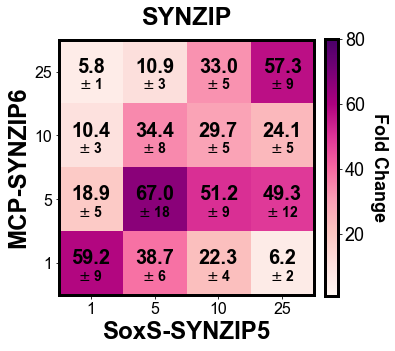

In [75]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'RdPu', vmin = 1, vmax = 80)
xlabels = ['1','5','10','25']
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 20)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 14)
plt.ylabel('MCP-SYNZIP6', size = 24)
plt.xlabel('SoxS-SYNZIP5', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
plt.yticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.title('SYNZIP', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('szp_heatmap.svg')

In [63]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(ABA_FA,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(ABA_Err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []
        
#for i,x in enumerate(FA_2D):
#    FA_2D[i] = list(reversed(x))
#    Err_2D[i] = list(reversed(Err_2D[i]))
#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))

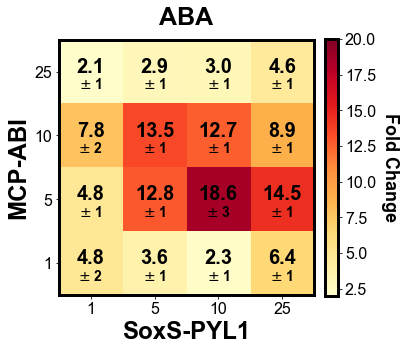

In [64]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'YlOrRd', vmin = 2, vmax = 20)
xlabels = ['1','5','10','25']
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 20)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 14)
plt.ylabel('MCP-ABI', size = 24)
plt.xlabel('SoxS-PYL1', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
plt.yticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.title('ABA', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('aba_heatmap.svg')

In [57]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(GA_FA,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(GA_Err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []

#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))

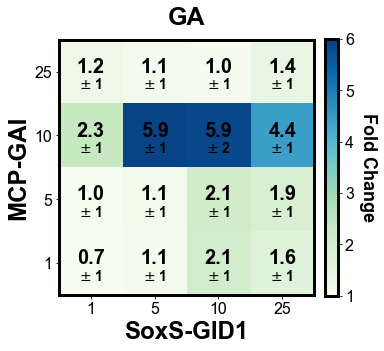

In [62]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'GnBu', vmin = 1, vmax = 6)
xlabels = ['1','5','10','25']
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 20)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 14)
plt.ylabel('MCP-GAI', size = 24)
plt.xlabel('SoxS-GID1', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
plt.yticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.title('GA', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('ga_heatmap.svg')

## S4: Combinatorial promoter assembly

In [34]:
promoter_FA = [
194.4902188,	199.9445679,	399.1933387,	47.97800077,	
228.1047163,	236.4691925,	269.0547205,	84.49275759,	
177.4512849,	170.677365,	303.1922223,	65.03802218,	
192.6467706,	155.0507581,	205.6296537,	67.56209857]

promoter_err = [
33.84728936,	16.12909602,	94.94420759,	0.600263868,
4.406779423,	24.67585905,	9.194229197,	3.552926618,
10.15001021,	21.71830581,	16.52071631,	2.592552575,
10.27796154,	5.459053797,	21.76143573,	5.783544203]


In [35]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(promoter_FA,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(promoter_err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []

#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))
FA_2D = np.array(FA_2D).T

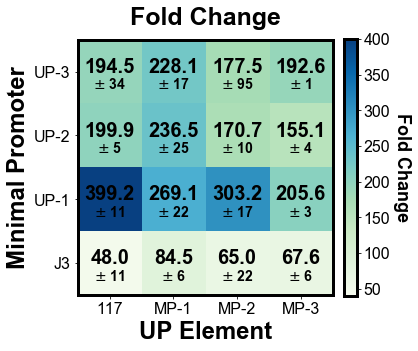

In [36]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'GnBu', vmin = 40, vmax = 400)
xlabels = ['117','MP-1','MP-2','MP-3']
ylabels = ['J3','UP-1','UP-2','UP-3']

plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 20)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 14)
plt.ylabel('Minimal Promoter', size = 24)
plt.xlabel('UP Element', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
#plt.xticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.yticks(ticks = [3, 2, 1, 0],labels = ylabels, fontsize = 16)

plt.title('Fold Change', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('promoter_FA_heatmap.svg')

In [32]:
promoter_on = [
8866.06792,	12478.45291,	12720.78047,	10148.40347,
12560.06105,	15257.66438,	14005.11252,	12859.02221,
6605.683973,	8032.089934,	7383.395425,	7032.883993,
7184.577871,	8991.727876,	8436.86537,	7351.691556
]

promoter_on_err = [
1525.141311,	292.1740948,	3020.783426,	75.24192104,
150.3659938,	904.3623391,	189.2588738,	280.8407311,
310.2936509,	558.6908255,	225.0250541,	277.594126,
67.81333073,	205.8784366,	642.9317042,	506.8833885
]

promoter_off = [
45.58618925,	62.40956202,	31.86621429,	211.5220166,
55.06269777,	64.52284217,	52.05302661,	152.1908218,
37.22533752,	47.06007697,	24.35219271,	108.134961,
37.29404779,	57.99215678,	41.02941972,	108.8138425
]

promoter_off_err = [
1.202498344,	4.817707422,	0.423592102,	2.131666498,
0.834894571,	5.541433445,	1.633779064,	5.468765154,
1.214925258,	5.014440303,	1.099959143,	0.602430247,
1.958301445,	1.55108048,	3.012917216,	5.520768727
]

In [45]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(promoter_off,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(promoter_off_err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []

#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))
FA_2D = np.array(FA_2D).T

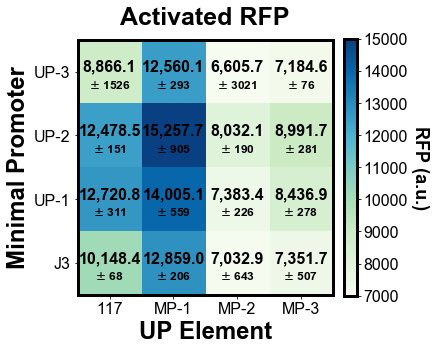

In [44]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'GnBu', vmin = 7000, vmax = 15000)
xlabels = ['117','MP-1','MP-2','MP-3']
ylabels = ['J3','UP-1','UP-2','UP-3']

plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('RFP (a.u.)', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 16)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 12)
plt.ylabel('Minimal Promoter', size = 24)
plt.xlabel('UP Element', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
#plt.xticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.yticks(ticks = [3, 2, 1, 0],labels = ylabels, fontsize = 16)

plt.title('Activated RFP', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('promoter_on_heatmap.svg')

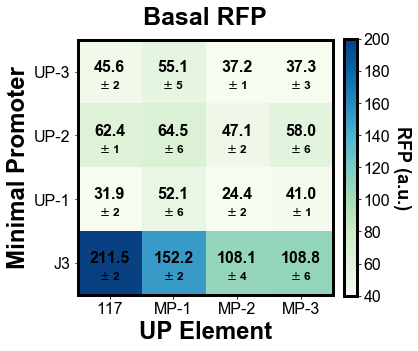

In [46]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'GnBu', vmin = 40, vmax = 200)
xlabels = ['117','MP-1','MP-2','MP-3']
ylabels = ['J3','UP-1','UP-2','UP-3']

plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('RFP (a.u.)', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 16)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 12)
plt.ylabel('Minimal Promoter', size = 24)
plt.xlabel('UP Element', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
#plt.xticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.yticks(ticks = [3, 2, 1, 0],labels = ylabels, fontsize = 16)

plt.title('Basal RFP', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('promoter_off_heatmap.svg')